In [1]:
train_path = 'data/training.csv'
test_path = 'data/test.csv'
look_up_path = 'data/IdLookupTable.csv'

In [50]:
import pandas as pd
from PIL import Image, ImageDraw
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import csv
import matplotlib.pyplot as plt

In [49]:
def print_image(image_ID):
    image_raw = []
    formatted_image = []
    for num in train_data['Image'][image_ID].split(' '):
        image_raw.append(int(num))

    for i in range(96):
        row = []
        for j in range(96):
            row.append(image_raw[i*96+j])
        formatted_image.append(row)

    img = Image.fromarray(np.array(formatted_image, dtype=np.uint8), mode='L').convert('RGB')
    draw = ImageDraw.Draw(img)
    point_columns = [col for col in train_data.columns if col != 'Image']
    points = train_data.iloc[0][point_columns].values.reshape(-1, 2)

    for point in points:
        draw.ellipse((point[0] - 1, point[1] - 1, point[0] + 1, point[1] + 1), fill='red', outline='red')
    img.show()

print_image(2)

# Data Cleanup 

Out of the 7,049 rows, 4,755 of these rows are missing 22 fields. We are going to average out those missing fields

In [52]:
# This ONLY includes rows that have data for at least 1 keypoint
# Rows that only contain image data are not included
train_data = pd.read_csv(train_path)

missing_image_rows = train_data['Image'].isnull().sum()
print(f"Rows missing 'Image' field: {missing_image_rows}\n")

missing_counts = train_data.isnull().sum(axis=1).value_counts().sort_index()
for missing_fields, row_count in missing_counts.items():
    if missing_fields > 0:
        print(f"Rows missing {missing_fields} field(s): {row_count}")

Rows missing 'Image' field: 0

Rows missing 2 field(s): 87
Rows missing 4 field(s): 28
Rows missing 6 field(s): 9
Rows missing 8 field(s): 8
Rows missing 10 field(s): 3
Rows missing 12 field(s): 5
Rows missing 14 field(s): 2
Rows missing 20 field(s): 2
Rows missing 22 field(s): 4755
Rows missing 24 field(s): 10


Since a significant amonut of rows contain blank values, we will fill in these values with the average for the column. 

In the future it would be worth experimenting with removing these rows instead of filling them out. For now we are going to go with the idea that lots of flawed synthetic data is better than a small amount of quality data. 

In [48]:
column_means = {}

# Iterate over each column index except the last one
for i in range(train_data.shape[1] - 1):
    column_name = train_data.columns[i]
    mean_value = train_data.iloc[:, i].mean()
    column_means[column_name] = mean_value
print(column_means)

# Fill missing values using the precomputed means, except for the "Image" column
for column_name, mean_value in column_means.items():
    train_data[column_name].fillna(mean_value, inplace=True)
    
# save train_data
# train_data.to_csv('data/avg_train_data.csv', index=False)

# Make sure no blank vals go through
missing_row = train_data[train_data.isnull().any(axis=1)]
print(missing_row)

{'left_eye_center_x': 66.35902124475366, 'left_eye_center_y': 37.65123419193395, 'right_eye_center_x': 30.30610151407975, 'right_eye_center_y': 37.97694257172699, 'left_eye_inner_corner_x': 59.15933943740389, 'left_eye_inner_corner_y': 37.94475232796771, 'left_eye_outer_corner_x': 73.33047798314611, 'left_eye_outer_corner_y': 37.707008310792986, 'right_eye_inner_corner_x': 36.652606948057254, 'right_eye_inner_corner_y': 37.9899019145105, 'right_eye_outer_corner_x': 22.384504479169358, 'right_eye_outer_corner_y': 38.03349517525054, 'left_eyebrow_inner_end_x': 56.068513079309284, 'left_eyebrow_inner_end_y': 29.332678249311712, 'left_eyebrow_outer_end_x': 79.48282586419953, 'left_eyebrow_outer_end_y': 29.734860732432317, 'right_eyebrow_inner_end_x': 39.32213692201747, 'right_eyebrow_inner_end_y': 29.50299847411299, 'right_eyebrow_outer_end_x': 15.871177472719154, 'right_eyebrow_outer_end_y': 30.428165911873432, 'nose_tip_x': 48.37418629032876, 'nose_tip_y': 62.71588359736171, 'mouth_left_

/var/folders/kp/vdv61pd97vd0x29b257r8h7h0000gn/T/ipykernel_1534/2586996622.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[column_name].fillna(mean_value, inplace=True)


There seems to be some outliars in the training data. Not enough to make a big deal over though. 

Need more investigation to these outliars to see if they are legitimate or not.

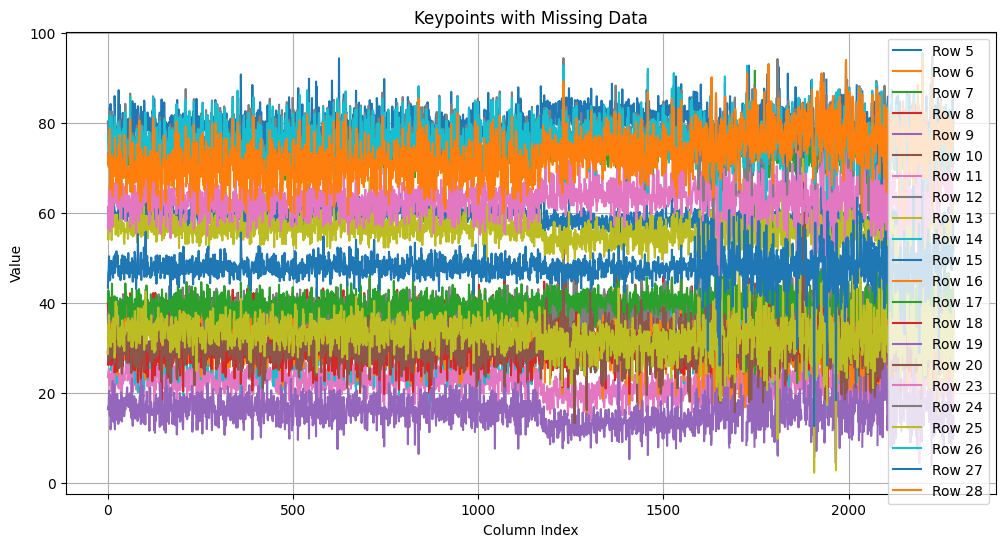

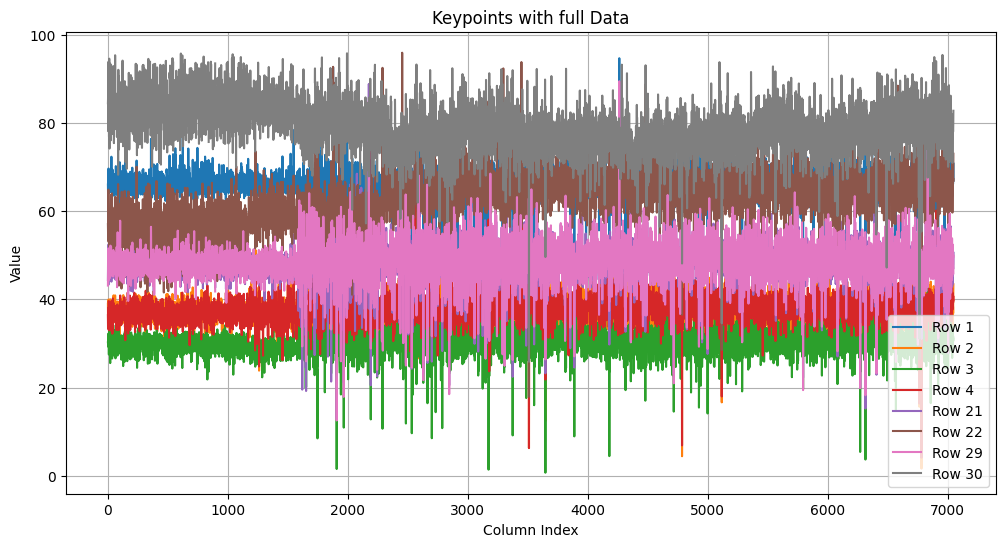

In [110]:
# Graph of keypoints that do not have enough data
plt.figure(figsize=(12, 6))

for i in range(4, 20):
    plt.plot(train_data.iloc[:, i], label=f'Row {i+1}')
    
plt.plot(train_data.iloc[:, 22], label=f'Row {23}')
plt.plot(train_data.iloc[:, 23], label=f'Row {24}')
plt.plot(train_data.iloc[:, 24], label=f'Row {25}')
plt.plot(train_data.iloc[:, 25], label=f'Row {26}')
plt.plot(train_data.iloc[:, 26], label=f'Row {27}')
plt.plot(train_data.iloc[:, 27], label=f'Row {28}')

plt.title('Keypoints with Missing Data')
plt.xlabel('Column Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


# Graph 2
plt.figure(figsize=(12, 6))
plt.plot(train_data.iloc[:, 0], label=f'Row {1}')
plt.plot(train_data.iloc[:, 1], label=f'Row {2}')
plt.plot(train_data.iloc[:, 2], label=f'Row {3}')
plt.plot(train_data.iloc[:, 3], label=f'Row {4}')
plt.plot(train_data.iloc[:, 20], label=f'Row {21}')
plt.plot(train_data.iloc[:, 21], label=f'Row {22}')

plt.plot(train_data.iloc[:, 28], label=f'Row {29}')
plt.plot(train_data.iloc[:, 29], label=f'Row {30}')
    
plt.title('Keypoints with full Data')
plt.xlabel('Column Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()